In [22]:
from utils import *
print('Project root directory:', PROJ_DIR)
#print('Results directory:     ', RES_DIR)

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os

Project root directory: C:\Users\Fedor\Documents\GRiPE


In [34]:
def check_dict_params(dp):
    #if float(dp[TOTAL_SIM_TIME]) != 10000.: return False
    #if int(dp[ENSAMBLE_SIZE]) != 1000: return False
    #if int(dp['RANDOM_SEED']) != 0: return False
    return True

def check_tf_params(dftf):
    if len(dftf) != 1: return False
    # no facilitated diffusion
    if float(dftf[UNBIND_PROB][0]) != 1.0: return False
    # no 3D diffusion
    #if float(dftf[UNBIND_PROB][0]) != 0.0: return False
    return True

In [35]:
# get results file names
#dp = {TOTAL_SIM_TIME: '1000.0', ENSAMBLE_SIZE: '1000'}
#tf_list = ['Kr', 'hb', 'gt', 'kni', 'bcd', 'cad', 'tll', 'hkb']
#dftf = pd.DataFrame([['1','0.']]*len(tf_list), columns=[COPY_NUMBER, UNBIND_PROB], index=tf_list)
#dftf = pd.DataFrame(['1',], columns=[COPY_NUMBER], index=[tf_list[0]])
res_dirs, prefixes, ids = get_results_match_params(os.path.join(PROJ_DIR, RES_DIR), check_dict_params, check_tf_params)
print(res_dirs, prefixes, ids)

Something wrong with the TF file in C:\Users\Fedor\Documents\GRiPE\results, id 12118358867738410737.
Something wrong with the TF file in C:\Users\Fedor\Documents\GRiPE\results, id 14613919256255676409.
Something wrong with the TF file in C:\Users\Fedor\Documents\GRiPE\results, id 1696428307879613927.
['C:\\Users\\Fedor\\Documents\\GRiPE\\results\\drosophila_kr_1_no_repr_no_facilit', 'C:\\Users\\Fedor\\Documents\\GRiPE\\results\\drosophila_kr_1_no_repr_no_facilit'] ['drosoph_kr_1_hb', 'drosoph_kr_1_kr'] ['2470709189931105060', '1170263794088494801']


In [44]:
k = -2
res_dir = res_dirs[k]
prefix = prefixes[k]
id = ids[k]

In [45]:
# parameters of experinemt (directory, file prefix and experiment id)
#dir = os.path.join(PROJ_DIR, 'results', 'test_no_repr_long_dna')
#res_dir = os.path.join(PROJ_DIR, RES_DIR, 'drosophila_kr_1_no_repr_no_facilit')
#par_dir = os.path.join(PROJ_DIR, BIODATA_DIR, 'drosophila_kr')
#prefix = 'drosoph_kr_1'
#id = 1876307244743812423
#id = '15955359011230914012'
#id = '3050453005152332055' #'11978643740589520233'#15528920285518599178'
#id = '7972853261792450352'
#id = '5872830590912705837'#'12546903617970327114'

In [46]:
# load occupancy (occupancy.wig)
df_occupancy = read_wig_to_dataframe(get_name(res_dir, prefix, OCCUPANCY, id, 'wig'), index=0)
df_occupancy['collisionsCount'] = np.array(df_occupancy['collisionsCount'], dtype=int)
# load energies (PFM-based)
df_site_energy = read_wig_to_dataframe(get_name(res_dir, prefix, ENERGY, id, 'wig'), index=0)
# load tf data
df_tf_data = read_csv_to_dataframe(get_name(res_dir, prefix, TF_SPECIES, id, 'csv'))
# load params
dict_params = read_params_to_dict(get_name(res_dir, prefix, PARAMS, id, 'grp'))
# load target sites
ts_filename = os.path.join(PROJ_DIR, *dict_params[TS_FILE].split(DIR_SEP))
df_target_sites = create_target_site_df(ts_filename, df_tf_data, df_site_energy)
# some important numbers from parameters
total_time = float(dict_params[TOTAL_SIM_TIME])
ensemble_size = int(dict_params[ENSAMBLE_SIZE])
print(TOTAL_SIM_TIME + ':', total_time)
print(ENSAMBLE_SIZE + ':', ensemble_size)
positions = np.array(df_occupancy.index-12000)
positions_i = np.array(df_occupancy.index)
# load positions availability (btrack)
btrack_path = os.path.join(PROJ_DIR, *dict_params[BTRACK].split(DIR_SEP))
if os.path.isfile(btrack_path):
    btrack = np.loadtxt(btrack_path, dtype=int)
else:
    print('No btrack file, the whole chromatin is assumed to be open')
    btrack = np.ones_like(positions)

STOP_TIME: 10000.0
ENSAMBLE_SIZE: 100000
No btrack file, the whole chromatin is assumed to be open


In [47]:
total_bind_time = np.sum(df_occupancy.to_numpy(), axis=0)[1:] / ensemble_size
total_bind_time = double_each_element(np.sum(total_bind_time.reshape(-1,2), axis=1))
print(total_bind_time)

[669.81621275 669.81621275]


In [48]:
def is_opened(bp_i, motif_len, btrack):
    if np.sum(btrack[bp_i: bp_i+motif_len]) < motif_len:
        return False
    return True

In [49]:
#%% Probability of each energy
tf_list = np.array(df_tf_data.index, dtype=str)
tf_num = len(tf_list)
tf_size = np.array([get_motif_size(df_tf_data.at[tf_list[i], MOTIF])
                    + int(df_tf_data.at[tf_list[i], SIZE_LEFT])
                    + int(df_tf_data.at[tf_list[i], SIZE_RIGHT]) for i in range(tf_num)], dtype=int)

tf_list_2dir = df_site_energy.columns
tf_num_2dir = len(tf_list_2dir)

if tf_num != tf_num_2dir:
    # 2 directions
    both_dir = True
    tf_size_2dir = double_each_element(tf_size)
else:
    # 1 direction
    both_dir = False
    tf_size_2dir = tf_size

nonspecific_time = np.array(df_tf_data[NONSPEC_WAITING_TIME], dtype=float)
if both_dir:
    nonspecific_time = double_each_element(nonspecific_time)
energy = np.array(df_site_energy.to_numpy().transpose())
for tf_i in range(tf_num_2dir):
    # last positions which TFs cannot reach
    energy[tf_i,-tf_size_2dir[tf_i]+1:] = -np.inf
    # closed dna regions
    for bp_i in positions_i:
        if not is_opened(bp_i, tf_size_2dir[tf_i], btrack):
            energy[tf_i,bp_i] = -np.inf

#energy_exponent = np.einsum('i,ij->ij', nonspecific_time, np.exp(energy)) / total_time
energy_exponent = np.exp(energy)
energy_exp_sum = np.zeros(tf_num_2dir)
for tf_i in range(tf_num_2dir):
    if both_dir:
        #energy_exp_sum[tf_i] = np.sum(np.exp(energy[tf_i]))
        ind = (tf_i // 2) * 2 # or tf_i - (tf_i%2)
        for s in range(2):
            sites_strand = df_target_sites.loc[df_target_sites.name_strand == tf_list_2dir[ind+s]].pos.to_numpy(dtype=int)
            #energy_exp_sum[tf_i] += np.sum(np.exp(energy[ind+s][sites_strand]))
            energy_exp_sum[tf_i] += np.sum(np.exp(energy[ind+s]))
    else:
        energy_exp_sum[tf_i] = np.sum(np.exp(energy[tf_i]))
print(energy_exp_sum)
energy_prob = np.einsum('i,ij->ij', 1/energy_exp_sum, energy_exponent)
#energy_prob = energy_exponent / np.sum(energy_exponent)*2
occupancy_from_exper = df_occupancy.to_numpy().transpose()[1:] / ensemble_size
#occupancy_from_exper /= total_time
occupancy_from_exper = np.einsum('i,ij->ij', 1/total_bind_time, occupancy_from_exper)

[17.22987937 17.22987937]


83


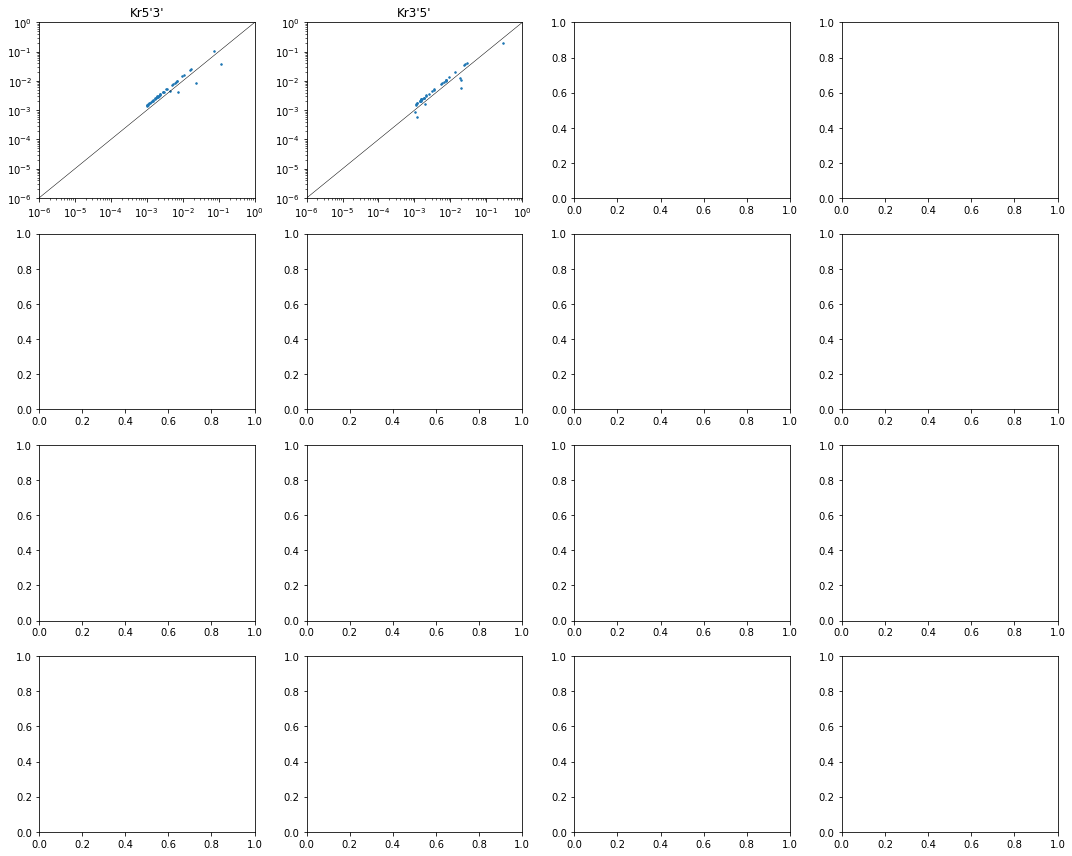

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(15,12), tight_layout=True)
snum = 0
for tf_i in range(tf_num_2dir):
    ax_i = ax[tf_i//4, tf_i%4]
    sites = df_target_sites.loc[df_target_sites.name_strand == tf_list_2dir[tf_i]].pos.to_numpy(dtype=int)
    #ax_i.ylabel('occupancy ($\\tau/\\tau_{total}$)')
    #plt.xlabel('affinity ($e^{PWM}$)')
    #ax_i.xlabel('equilibrium prob. ($e^{PWM} / Z$)')
    snum += len(sites)
    c = 'C0'# + str(tf_i)
    ax_i.loglog(energy_prob[tf_i][sites], occupancy_from_exper[tf_i][sites], lw=0, ms=3, marker='.', c=c)
    ax_i.plot([10**-8, 10**2], [10**-8, 10**2], c='k', lw=0.5)
    lims = [10**-6, 10**0]
    ax_i.set_xlim(lims)
    ax_i.set_ylim(lims)
    ax_i.set_title(tf_list_2dir[tf_i])
print(snum)
plt.show()

83


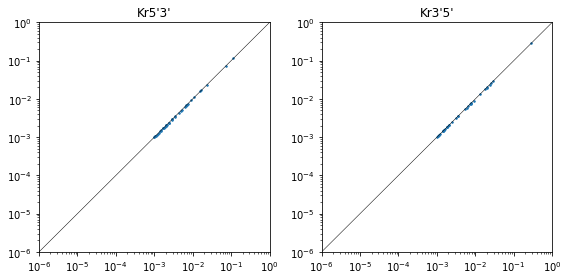

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
snum = 0
for tf_i in range(tf_num_2dir):
    ax_i = ax[tf_i%2]
    sites = df_target_sites.loc[df_target_sites['name_strand'] == tf_list_2dir[tf_i]]['pos'].to_numpy(dtype=int)
    #ax_i.ylabel('occupancy ($\\tau/\\tau_{total}$)')
    #plt.xlabel('affinity ($e^{PWM}$)')
    #ax_i.xlabel('equilibrium prob. ($e^{PWM} / Z$)')
    snum += len(sites)
    c = 'C0'# + str(tf_i)
    ax_i.loglog(energy_prob[tf_i][sites], occupancy_from_exper[tf_i][sites], lw=0, ms=3, marker='.', c=c)
    ax_i.plot([10**-8, 10**2], [10**-8, 10**2], c='k', lw=0.5)
    lims = [10**-6, 10**0]
    ax_i.set_xlim(lims)
    ax_i.set_ylim(lims)
    ax_i.set_title(tf_list_2dir[tf_i])
print(snum)
plt.show()

In [43]:
fig.savefig(os.path.join(PROJ_DIR, FIG_DIR, 'kr_1_no_facilit.pdf'))

489


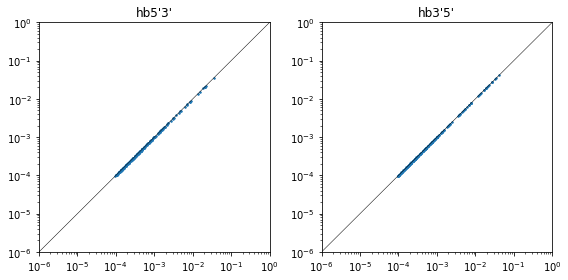

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
snum = 0
for tf_i in range(tf_num_2dir):
    ax_i = ax[tf_i%2]
    sites = df_target_sites.loc[df_target_sites['name_strand'] == tf_list_2dir[tf_i]]['pos'].to_numpy(dtype=int)
    #ax_i.ylabel('occupancy ($\\tau/\\tau_{total}$)')
    #plt.xlabel('affinity ($e^{PWM}$)')
    #ax_i.xlabel('equilibrium prob. ($e^{PWM} / Z$)')
    snum += len(sites)
    c = 'C0'# + str(tf_i)
    ax_i.loglog(energy_prob[tf_i][sites], occupancy_from_exper[tf_i][sites], lw=0, ms=3, marker='.', c=c)
    ax_i.plot([10**-8, 10**2], [10**-8, 10**2], c='k', lw=0.5)
    lims = [10**-6, 10**0]
    ax_i.set_xlim(lims)
    ax_i.set_ylim(lims)
    ax_i.set_title(tf_list_2dir[tf_i])
print(snum)
plt.show()

In [51]:
fig.savefig(os.path.join(PROJ_DIR, FIG_DIR, 'hb_1_no_facilit.pdf'))

In [177]:
np.argmax(df_target_sites['energy'])

662

In [183]:
df_target_sites_sorted = df_target_sites.sort_values('energy', ascending=False)

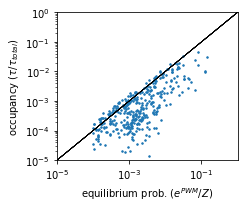

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3), tight_layout=True)
for tf_i in range(tf_num_2dir):
    sites = df_target_sites.loc[df_target_sites['name_strand'] == tf_list_2dir[tf_i]]['pos'].to_numpy(dtype=int)
    plt.ylabel('occupancy ($\\tau/\\tau_{total}$)')
    #plt.xlabel('affinity ($e^{PWM}$)')
    plt.xlabel('equilibrium prob. ($e^{PWM} / Z$)')
    plt.loglog(energy_exponent[tf_i][sites] / energy_exp_sum[tf_i], occupancy_from_exper[tf_i][sites], 
               lw=0, ms=3, marker='.', c='C0')
    plt.plot([10**-8, 10**2], [10**-8, 10**2], c='k', lw=0.5)

lims = [10**-5, 10**0]
plt.xlim(lims)
plt.ylim(lims)
plt.show()

In [ ]:
fig.savefig(os.path.join(PROJ_DIR, FIG_DIR, 'drosoph_kr_occupancy_vs_affinity.pdf'))

In [ ]:
fig.savefig(os.path.join(PROJ_DIR, FIG_DIR, 'drosoph_kr_no_repr_occupancy_vs_affinity.pdf'))

In [ ]:
energy_flat = []
occupancy_flat = []
for tf_i in range(tf_num_2dir):
    sites = df_target_sites.loc[df_target_sites['name_strand'] == tf_list_2dir[tf_i]]['pos'].to_numpy(dtype=int)
    idx_to_add = occupancy_from_exper[tf_i][sites] > 10**-4
    energy_flat.extend(energy[tf_i][sites][idx_to_add])
    occupancy_flat.extend(occupancy_from_exper[tf_i][sites][idx_to_add])
energy_flat = np.array(energy_flat)
occupancy_flat = np.array(occupancy_flat)

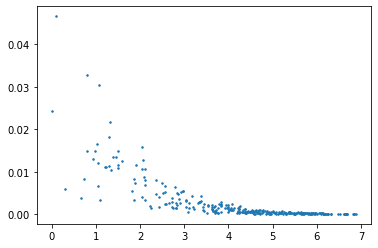

In [ ]:
plt.plot(-energy_flat, occupancy_flat, lw=0, ms=3, marker='.')

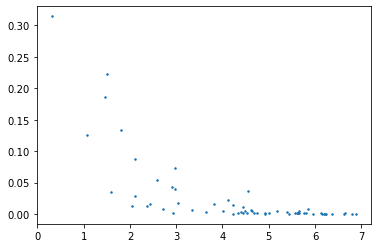

In [ ]:
plt.plot(-energy_flat, occupancy_flat, lw=0, ms=3, marker='.')

In [61]:
df_occupancy.columns[[1,2]]

Index(['Kr5'3'', 'Kr3'5''], dtype='object')

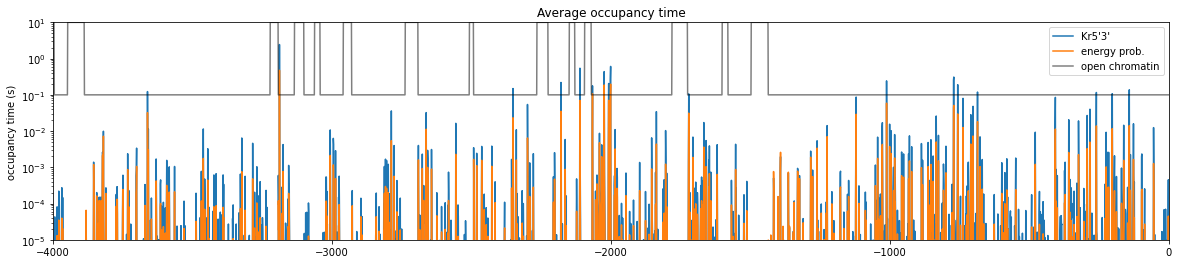

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(20,4))
ax.set_title('Average occupancy time')
ax.set_ylabel('occupancy time (s)')
for tf_i in range(1):
    tf = df_occupancy.columns[1+tf_i]
    ax.plot(positions, df_occupancy[tf]/ensemble_size, label=tf)
    #df_occupancy.plot(y=[i for i in range(1,2)], ax=ax)
    ax.plot(positions, 5*energy_prob[tf_i], alpha=1, label='energy prob.')
ax.plot(positions, -btrack, c='k', alpha=0.5, label='open chromatin')
ax.set_xticks(np.linspace(positions[0], positions[-1], 19))
ax.legend()
ax.set_xlim([-4000, 0])
log=True
if log:
    ax.set_yscale('log')
    ax.set_ylim([10**-5, 10])
    ax.plot(positions, 10-9.9*btrack, c='k', alpha=0.5, label='open chromatin')
plt.show()

In [98]:
open_len = 0
for i, bp_status in enumerate(btrack):
    open_len += bp_status
    if bp_status == 0 and open_len > 0:
        print(positions[i]-open_len, open_len, positions[i])
        open_len = 0

-7418 527 -6891
-3995 48 -3947
-3887 666 -3221
-3192 58 -3134
-3100 38 -3062
-3042 83 -2959
-2929 192 -2737
-2691 184 -2507
-2492 227 -2265
-2225 76 -2149
-2129 35 -2094
-2070 289 -1781
-1725 124 -1601
-1580 83 -1497
-1436 1466 30
81 32 113
929 30 959
3724 29 3753
4786 20 4806


In [25]:
df_site_energy

,Kr5'3',Kr3'5',hb5'3',hb3'5',gt5'3',gt3'5',kni5'3',kni3'5',bcd5'3',bcd3'5',cad5'3',cad3'5',tll5'3',tll3'5',hkb5'3',hkb3'5'
position,,,,,,,,,,,,,,,,
0,-11.6886,-15.9445,-29.3857,-16.1934,-31.7303,-16.8469,-17.7806,-11.9107,-10.6858,-10.5983,-15.2363,-21.5151,-26.6436,-16.9033,-21.5950,-14.1750
1,-12.2086,-19.6698,-24.2660,-18.1241,-20.6823,-18.9304,-22.5690,-21.1310,-17.6363,-17.4867,-18.3426,-19.4584,-24.0087,-17.9447,-26.4507,-21.3547
2,-10.9674,-27.1959,-24.7377,-16.7245,-21.0660,-24.2276,-27.8003,-20.7559,-22.7461,-11.8643,-15.1827,-15.3856,-18.8917,-7.9560,-14.5377,-20.5421
3,-17.4338,-27.0725,-24.5585,-15.6414,-25.4701,-23.4955,-27.9048,-20.4671,-20.3297,-17.4115,-16.7822,-18.8332,-19.6114,-12.3936,-18.6443,-29.0087
4,-20.6411,-18.6009,-25.9883,-10.4498,-29.2267,-17.7223,-23.2482,-13.1851,-18.8001,-15.9114,-12.4774,-18.4211,-20.2307,-21.7764,-23.5593,-25.0294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
17997,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
17998,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [2]:
df_target_sites

,repressor,name,name_strand,pos,size,strand,energy
0,False,bcd,bcd5'3',14,8,0,11.9074
1,False,gt,gt3'5',14,13,1,24.1155
2,False,cad,cad3'5',19,11,1,23.5160
3,False,gt,gt3'5',33,13,1,19.4095
4,False,hb,hb5'3',50,11,0,13.0408
...,...,...,...,...,...,...,...
1219,False,hb,hb3'5',17858,11,1,15.3219
1220,False,gt,gt3'5',17860,13,1,21.8241
1221,False,gt,gt3'5',17894,13,1,14.4808
1222,False,hb,hb5'3',17987,11,0,0.0000


In [3]:
# load master file
master_dir = os.path.join(PROJ_DIR, 'biodata', 'drosophila_master')
master_file = os.path.join(master_dir, 'result_upstream12k_downstream6k_hkbadd.xls')
dict_master = pd.read_excel(master_file, sheet_name=None)

In [4]:
dict_master['Kr']

,tf,PWM score,chromosome,glob. start,glob. end,glob. strand,glob. word,loc. start,loc. end,loc. strand,loc. word,best cluster P-value,ChIP-Seq peak height,overlaps rep. constructs,overlaps DNAse acc. regions,hits neighboring genes
0,bcd,3.990082,chr2R,21102151,21102158,+,GTATTAG,-11986,-11979,+,GTATTAG,0.747875,0.000,no,no,no
1,bcd,4.075856,chr2R,21102558,21102565,-,AAAATCC,-11579,-11572,-,AAAATCC,0.943873,0.013,no,no,no
2,bcd,5.745742,chr2R,21104551,21104558,-,TTAATCT,-9586,-9579,-,TTAATCT,2.116179,0.000,no,no,no
3,bcd,6.465945,chr2R,21104567,21104574,-,CTAATCT,-9570,-9563,-,CTAATCT,2.116179,0.000,no,no,no
4,bcd,5.062177,chr2R,21104715,21104722,-,CTAATTC,-9422,-9415,-,CTAATTC,0.992124,0.000,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,gt,4.480987,chr2R,21119712,21119724,+,aatgggtaacac,5575,5587,+,aatgggtaacac,3.459304,0.047,no,no,no
1220,gt,7.484714,chr2R,21119732,21119744,+,aatatgtaagaa,5595,5607,+,aatatgtaagaa,3.459304,0.020,no,no,no
1221,gt,3.887716,chr2R,21119926,21119938,+,ATAACGCATAAC,5789,5801,+,ATAACGCATAAC,1.674795,0.053,no,no,no
1222,gt,4.059812,chr2R,21119997,21120009,-,TTCTTGCTGTTT,5860,5872,-,TTCTTGCTGTTT,1.868152,0.047,no,no,no


In [9]:
master_kr = dict_master['Kr']
tf = master_kr['tf'].to_list()
sites = [site.lower() for site in master_kr['loc. word'].to_list()]
scores = []

dict_pwms = get_pwms(df_tf_data)
for i, site in enumerate(sites):
    score = 0
    pwm = dict_pwms[tf[i]]
    if master_kr.at[i, 'loc. strand'] == '-':
        # reverse complementary if on the opposite strand
        site = [complementary(bp) for bp in site[::-1]]
    for j, bp in enumerate(site):
        score += pwm[bp_to_idx(bp)][j]
    scores.append(score)

['g', 'g', 'a', 't', 't', 't', 't']


In [10]:
master_kr['PWM score 2'] = scores

In [11]:
master_kr[['tf', 'PWM score', 'PWM score 2', 'loc. word']]

,tf,PWM score,PWM score 2,loc. word
0,bcd,3.990082,3.9900,GTATTAG
1,bcd,4.075856,4.0759,AAAATCC
2,bcd,5.745742,5.7456,TTAATCT
3,bcd,6.465945,6.4658,CTAATCT
4,bcd,5.062177,5.0621,CTAATTC
...,...,...,...,...
1219,gt,4.480987,4.4810,aatgggtaacac
1220,gt,7.484714,7.4847,aatatgtaagaa
1221,gt,3.887716,3.8878,ATAACGCATAAC
1222,gt,4.059812,4.0598,TTCTTGCTGTTT


In [13]:
-df_target_sites['energy'].to_numpy()

array([-11.9074, -24.1155, -23.516 , ..., -14.4808,  -0.    ,  -0.    ])

In [15]:
master_kr.sort_values('loc. start')

,tf,PWM score,chromosome,glob. start,glob. end,glob. strand,glob. word,loc. start,loc. end,loc. strand,loc. word,best cluster P-value,ChIP-Seq peak height,overlaps rep. constructs,overlaps DNAse acc. regions,hits neighboring genes,PWM score 2
0,bcd,3.990082,chr2R,21102151,21102158,+,GTATTAG,-11986,-11979,+,GTATTAG,0.747875,0.000,no,no,no,3.9900
1065,gt,4.985296,chr2R,21102151,21102163,-,GTATTAGTTATT,-11986,-11974,-,GTATTAGTTATT,1.918192,0.027,no,no,no,4.9852
95,cad,4.458539,chr2R,21102156,21102166,-,AGTTATTAAG,-11981,-11971,-,AGTTATTAAG,0.674094,0.000,no,no,no,4.4587
1066,gt,4.948587,chr2R,21102170,21102182,-,TTGTTACATATA,-11967,-11955,-,TTGTTACATATA,1.918192,0.033,no,no,no,4.9486
434,hb,4.758241,chr2R,21102187,21102197,+,TGTAAAAAAT,-11950,-11940,+,TGTAAAAAAT,0.784403,0.047,no,no,no,4.7581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,hb,4.957841,chr2R,21119995,21120005,-,GTTTCTTGCT,5858,5868,-,GTTTCTTGCT,1.414146,0.200,no,no,no,4.9578
1222,gt,4.059812,chr2R,21119997,21120009,-,TTCTTGCTGTTT,5860,5872,-,TTCTTGCTGTTT,1.868152,0.047,no,no,no,4.0598
1223,gt,5.949660,chr2R,21120031,21120043,-,TTTTTATATATC,5894,5906,-,TTTTTATATATC,1.868152,0.053,no,no,no,5.9497
921,hb,4.284202,chr2R,21120124,21120134,+,AATAGAAAAA,5987,5997,+,AATAGAAAAA,0.625387,0.153,no,yes,no,4.2841


# Old figures

In [10]:
df_target_sites.loc[df_target_sites['name_strand'] == "Kr5'3'"]['pos'].to_numpy(dtype=int)

array([  403,   422,   567,  1711,  3218,  3432,  3671,  3687,  3789,
        4108,  4957,  4958,  5151,  5169,  5782,  6459,  8339,  8812,
        9821,  9889,  9934,  9975,  9976,  9992,  9998,  9999, 10279,
       10988, 11228, 11229, 11243, 12560, 12685, 13108, 13450, 13702,
       13822, 14806, 15829, 16279, 16351, 16600, 17532])

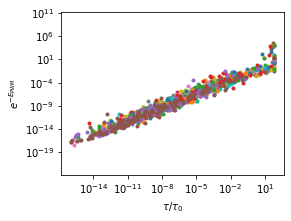

In [4]:
#%% Probability of each energy
tf_list = np.array(df_tf_data.index, dtype=str)
tf_num = len(tf_list)
tf_size = np.array([get_motif_size(df_tf_data.at[tf_list[i], MOTIF])
                    + int(df_tf_data.at[tf_list[i], SIZE_LEFT])
                    + int(df_tf_data.at[tf_list[i], SIZE_RIGHT]) for i in range(tf_num)], dtype=int)

tf_list_2dir = df_site_energy.columns[1:]
tf_num_2dir = len(tf_list_2dir)

if tf_num != tf_num_2dir:
    # 2 directions
    both_dir = True
    tf_size_2dir = double_each_element(tf_size)
else:
    # 1 direction
    both_dir = False
    tf_size_2dir = tf_size

nonspecific_time = np.array(df_tf_data[NONSPEC_WAITING_TIME], dtype=float)
total_time = float(dict_params[TOTAL_SIM_TIME])
assoc_rate = np.array(df_tf_data[ASSOC_RATE], dtype=float)
unbind_prob = np.array(df_tf_data[UNBIND_PROB], dtype=float) * np.array(df_tf_data[JUMP_PROB], dtype=float)
if both_dir:
    assoc_rate = double_each_element(assoc_rate)
    #np.array([[assoc_rate[i],]*2 for i in range(tf_num)]).reshape(tf_num_2dir)
    unbind_prob = double_each_element(unbind_prob)
    #np.array([[unbind_prob[i],]*2 for i in range(tf_num)]).reshape(tf_num_2dir)
    nonspecific_time = double_each_element(nonspecific_time)
    #np.array([[nonspecific_time[i],]*2 for i in range(tf_num)]).reshape(tf_num_2dir)
energy = df_site_energy.to_numpy().transpose()[1:]
for i in range(tf_num):
    energy[:,-tf_size[i]+1:] = +np.inf
energy_exponent = np.exp(-energy)
#prob_from_energy = (energy_exponent.T / (unbind_prob/assoc_rate/nonspecific_time + np.sum(energy_exponent, axis=1))).T
occupancy_from_exper = df_occupancy.to_numpy().transpose()[2:]

plt.figure(figsize=(4,3))
for tf_i in range(tf_num_2dir):
    sites = df_target_sites.loc[df_target_sites['name_strand'] == tf_list_2dir[tf_i]]['pos'].to_numpy(dtype=int)
    sites = np.arange(0, occupancy_from_exper.shape[1], 3)
    #plt.title(tf_list_2dir[tf_i])
    plt.xlabel('$\\tau/\\tau_0$')
    plt.ylabel('$e^{-E_{PWM}}$')
    plt.loglog(occupancy_from_exper[tf_i][sites]/nonspecific_time[tf_i], energy_exponent[tf_i][sites], lw=0, marker='.')

In [4]:
occupancy_from_exper.shape

(16, 18001)

In [33]:
np.array(df_tf_data[NONSPEC_WAITING_TIME], dtype=float).shape

(8,)

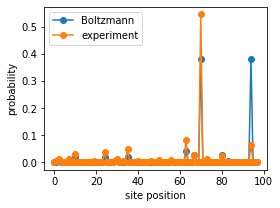

In [26]:
#%% Probability of each site
nonspecific_time = float(df_tf_data.at['Kr', NONSPEC_WAITING_TIME])
total_time = float(dict_params[TOTAL_SIM_TIME])
assoc_rate = float(df_tf_data.at['Kr', ASSOC_RATE])
unbind_prob = float(df_tf_data.at['Kr', UNBIND_PROB]) * float(df_tf_data.at['Kr', JUMP_PROB])
#prob_from_energy = np.exp(-df_site_energy['Kr'].to_numpy()[:-2]) * nonspecific_time / total_time
energy_exponent = np.exp(-df_site_energy['Kr'].to_numpy()[:-2])
prob_from_energy = energy_exponent / (unbind_prob/assoc_rate/nonspecific_time + np.sum(energy_exponent))
prob_from_exper = df_occupancy['Kr'].to_numpy()[:-2] / total_time
plt.figure(figsize=(4,3))
plt.plot(prob_from_energy, marker='o', label='Boltzmann')
plt.plot(prob_from_exper, marker='o', label='experiment')
plt.xlabel('site position')
plt.ylabel('probability')
plt.legend()

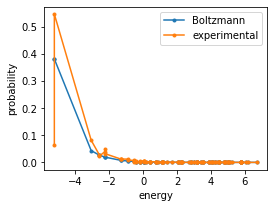

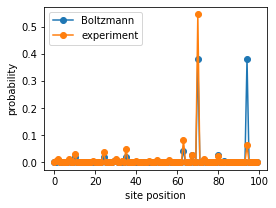

In [27]:
#%% Probability of each energy
tf_list = np.array(df_tf_data.index, dtype=str)
tf_num = len(tf_list)
tf_size = np.array([get_motif_size(df_tf_data.at[tf_list[i], MOTIF])
                    + int(df_tf_data.at[tf_list[i], SIZE_LEFT])
                    + int(df_tf_data.at[tf_list[i], SIZE_RIGHT]) for i in range(tf_num)], dtype=int)
nonspecific_time = np.array(df_tf_data[NONSPEC_WAITING_TIME], dtype=float)
total_time = float(dict_params[TOTAL_SIM_TIME])
assoc_rate = np.array(df_tf_data[ASSOC_RATE], dtype=float)
unbind_prob = np.array(df_tf_data[UNBIND_PROB], dtype=float) * np.array(df_tf_data[JUMP_PROB], dtype=float)
energy = df_site_energy.to_numpy().transpose()[1:]
for i in range(tf_num):
    energy[:,-tf_size[i]+1:] = +np.inf
energy_exponent = np.exp(-energy)
prob_from_energy = energy_exponent / (unbind_prob/assoc_rate/nonspecific_time + np.sum(energy_exponent, axis=1))
prob_from_exper = df_occupancy.to_numpy().transpose()[2:] / total_time

for tf_i in range(tf_num):
    sort_idx = np.argsort(energy[tf_i])
    #energy_cont = np.linspace(energy[tf_i][sort_idx][0], energy[tf_i][sort_idx][-tf_size[tf_i]], 101)
    #prob_from_energy_cont = np.exp(-energy_cont) / (unbind_prob[tf_i]/assoc_rate[tf_i]/nonspecific_time[tf_i] + np.exp(-energy_cont[0]) - np.exp(-energy_cont[-1]))
    
    plt.figure(figsize=(4,3))
    #plt.plot(energy_cont, prob_from_energy_cont, label='Boltzmann: continuous')
    plt.plot(energy[tf_i][sort_idx], prob_from_energy[tf_i][sort_idx], marker='.', label='Boltzmann')
    plt.plot(energy[tf_i][sort_idx], prob_from_exper[tf_i][sort_idx], marker='.', label='experimental')
    plt.xlabel('energy')
    plt.ylabel('probability')
    plt.legend()

    plt.figure(figsize=(4,3))
    plt.plot(prob_from_energy[tf_i], marker='o', label='Boltzmann')
    plt.plot(prob_from_exper[tf_i], marker='o', label='experiment')
    plt.xlabel('site position')
    plt.ylabel('probability')
    plt.legend()

In [12]:
np.sum(prob_from_energy)

0.9999999972394411

In [6]:
type(tf_list[0])

numpy.str_

/home/fedor/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


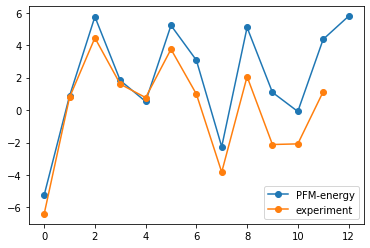

In [3]:
# %% Affinity landscape
nonspecific_time = float(df_tf_data.at['Kr', NONSPEC_WAITING_TIME])
df_affinity = df_occupancy.copy()
df_affinity['Kr'] = -np.log(df_occupancy['Kr']/nonspecific_time)
# plot energies
plt.figure()
plt.plot(df_site_energy['Kr'].to_numpy()[:-2], marker='o', label='PFM-energy')
plt.plot(df_affinity['Kr'].to_numpy()[:-2], marker='o', label='experiment')
plt.legend()